### Problem Statement

Insurance companies need to accurately predict the cost of health insurance for individuals to set premiums appropriately. However, traditional methods of cost prediction often rely on broad actuarial tables and historical averages, which may not account for the nuanced differences among individuals. By leveraging machine learning techniques, insurers can predict more accurately the insurance costs tailored to individual profiles, leading to more competitive pricing and better risk management.


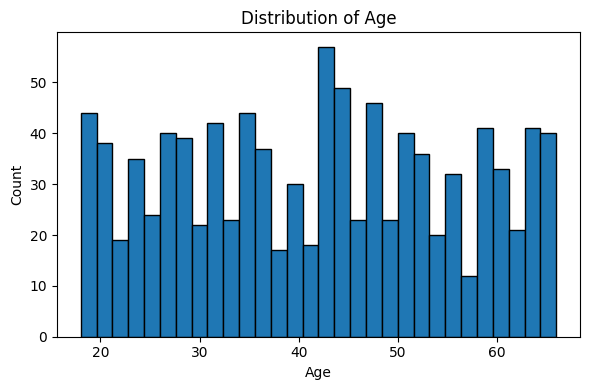

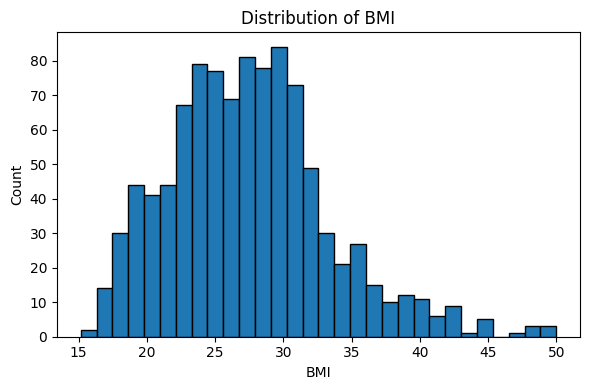

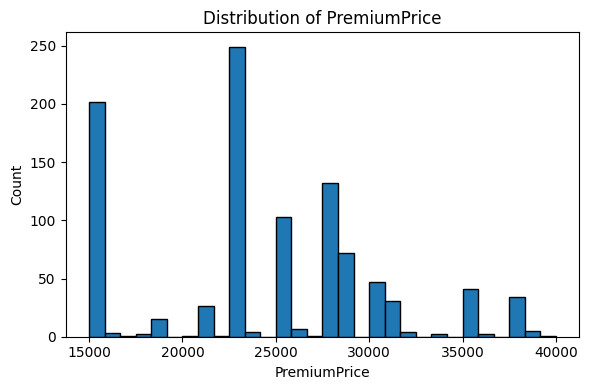

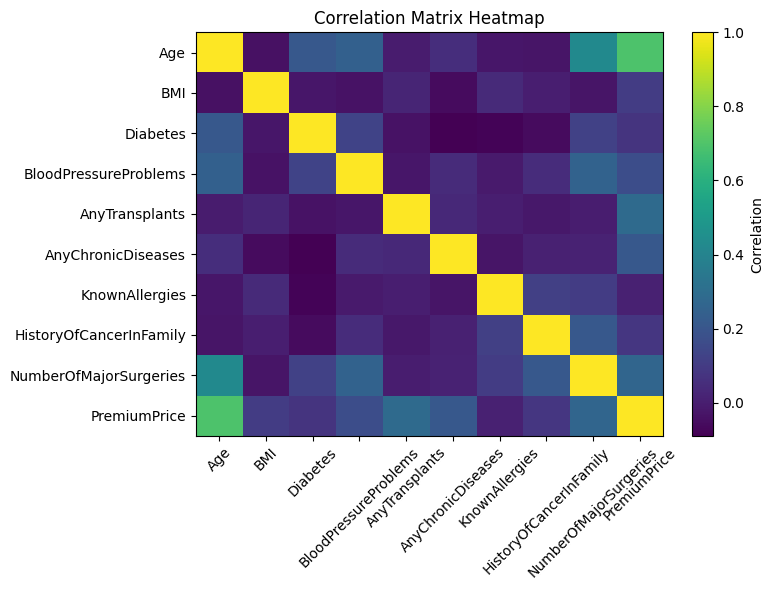

Outlier counts by variable:
  Age: 0
  BMI: 22
  PremiumPrice: 6


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import statsmodels.api as sm

# 1. Load the data
df = pd.read_csv(r'insurance.csv')

# 2. Feature engineering: compute BMI
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

# 3. Distribution Analysis
for var in ['Age', 'BMI', 'PremiumPrice']:
    plt.figure(figsize=(6,4))
    plt.hist(df[var], bins=30, edgecolor='k')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 4. Correlation Heatmap
corr = df[['Age','BMI','Diabetes','BloodPressureProblems','AnyTransplants',
           'AnyChronicDiseases','KnownAllergies','HistoryOfCancerInFamily',
           'NumberOfMajorSurgeries','PremiumPrice']].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# 5. Outlier Detection using IQR
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[(series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)]

outlier_summary = {var: detect_outliers(df[var]).shape[0]
                   for var in ['Age', 'BMI', 'PremiumPrice']}
print("Outlier counts by variable:")
for var, count in outlier_summary.items():
    print(f"  {var}: {count}")




## Hypothesis Testing


We’ll formally test whether key health flags and surgery counts truly shift average premiums.

##### Performing one-sided t-test

H₀ (null): The mean premium for individuals with chronic diseases equals the mean premium for those without chronic diseases.

H₁ (alternative): The mean premium for individuals with chronic diseases is higher than for those without.

In [ ]:
group_chronic    = df.loc[df['AnyChronicDiseases'] == 1, 'PremiumPrice']
group_no_chronic = df.loc[df['AnyChronicDiseases'] == 0, 'PremiumPrice']

t_stat, p_val = ttest_ind(group_chronic, group_no_chronic, equal_var=False)
print(f"Chronic vs. No Chronic: t = {t_stat:.3f}, p = {p_val:.3e}")
if p_val/2 < 0.05 and t_stat > 0:
    print("Reject H₀: premiums are significantly higher when chronic diseases are present.")
else:
    print("Fail to reject H₀.")

##### Performing one-way ANOVA

H₀ (null): All group means are equal across surgery counts (0, 1, 2, 3).

H₁ (alternative): The mean premium for individuals with chronic diseases is higher than for those without.

In [ ]:
surgery_groups = [
    df.loc[df['NumberOfMajorSurgeries'] == i, 'PremiumPrice']
    for i in sorted(df['NumberOfMajorSurgeries'].unique())
]

f_stat, p_val = f_oneway(*surgery_groups)
print(f"\nANOVA across surgery counts: F = {f_stat:.3f}, p = {p_val:.3e}")
if p_val < 0.05:
    print("Reject H₀: at least one surgery-count group differs in mean premium.")
else:
    print("Fail to reject H₀.")

In [12]:
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,45,0,0,0,0,155,57,0,0,0,25000,23.725286
1,60,1,0,0,0,180,73,0,0,0,29000,22.530864
2,36,1,1,0,0,158,59,0,0,1,23000,23.634033
3,52,1,1,0,1,183,93,0,0,2,28000,27.770313
4,38,0,0,0,1,166,88,0,0,1,23000,31.934969
...,...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000,23.458562
982,64,1,1,0,0,153,70,0,0,3,28000,29.903029
983,56,0,1,0,0,155,71,0,0,1,29000,29.552549
984,47,1,1,0,0,158,73,1,0,1,39000,29.242109


#### Chi-square tests

H₀ (null): There is no association between the presence of chronic diseases and the history of cancer in the family.

H₁ (alternative): There is an association between the presence of chronic diseases and the history of cancer in the family.

In [13]:
# Create a contingency table
contingency_table = pd.crosstab(df['AnyChronicDiseases'], df['HistoryOfCancerInFamily'])

# Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print("=== Chi-Square Test: Chronic Disease vs. Family History of Cancer ===")
print("Contingency Table:")
print(contingency_table)
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns))
print(f"\nChi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_val:.4f}")
print(f"Degrees of Freedom: {dof}")
if p_val < 0.05:
    print("Result: Reject Null Hypothesis – Significant association found.")
else:
    print("Result: Fail to Reject Null – No significant association.")

=== Chi-Square Test: Chronic Disease vs. Family History of Cancer ===
Contingency Table:
HistoryOfCancerInFamily    0   1
AnyChronicDiseases              
0                        714  94
1                        156  22

Expected Frequencies:
HistoryOfCancerInFamily           0          1
AnyChronicDiseases                            
0                        712.941176  95.058824
1                        157.058824  20.941176

Chi-Square Statistic: 0.0206
P-Value: 0.8858
Degrees of Freedom: 1
Result: Fail to Reject Null – No significant association.


In [14]:
import pandas as pd
from scipy.stats import ttest_ind

# Load dataset
df = pd.read_csv("insurance.csv")

# Binary categorical columns to test
binary_columns = [
    'Diabetes',
    'BloodPressureProblems',
    'AnyTransplants',
    'KnownAllergies',
    'HistoryOfCancerInFamily'
]

# Perform t-tests
print("=== T-Test Results on PremiumPrice ===")
for col in binary_columns:
    group0 = df[df[col] == 0]['PremiumPrice']
    group1 = df[df[col] == 1]['PremiumPrice']
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"\n{col}:")
    print(f"  T-statistic = {t_stat:.4f}")
    print(f"  P-value     = {p_val:.6f}")
    if p_val < 0.05:
        print("  → Significant difference in PremiumPrice.")
    else:
        print("  → No significant difference.")


=== T-Test Results on PremiumPrice ===

Diabetes:
  T-statistic = -2.4489
  P-value     = 0.014508
  → Significant difference in PremiumPrice.

BloodPressureProblems:
  T-statistic = -5.3703
  P-value     = 0.000000
  → Significant difference in PremiumPrice.

AnyTransplants:
  T-statistic = -6.2599
  P-value     = 0.000000
  → Significant difference in PremiumPrice.

KnownAllergies:
  T-statistic = -0.3667
  P-value     = 0.714092
  → No significant difference.

HistoryOfCancerInFamily:
  T-statistic = -2.3568
  P-value     = 0.019828
  → Significant difference in PremiumPrice.


In [ ]:
from scipy.stats import chi2_contingency
from itertools import combinations

# Binary categorical columns
binary_cat_cols = [
    'Diabetes',
    'BloodPressureProblems',
    'AnyTransplants',
    'AnyChronicDiseases',
    'KnownAllergies',
    'HistoryOfCancerInFamily'
]

# Perform chi-square tests
print("\n=== Chi-Square Test Results Between Binary Variables ===")
for col1, col2 in combinations(binary_cat_cols, 2):
    table = pd.crosstab(df[col1], df[col2])
    chi2_stat, p_val, dof, expected = chi2_contingency(table)
    print(f"\n{col1} vs {col2}:")
    print(f"  Chi-square statistic = {chi2_stat:.4f}")
    print(f"  P-value              = {p_val:.6f}")
    if p_val < 0.05:
        print("  → Significant association.")
    else:
        print("  → No significant association.")



=== Chi-Square Test Results Between Binary Variables ===

Diabetes vs BloodPressureProblems:
  Chi-square statistic = 15.5712
  P-value              = 0.000079
  → Significant association.

Diabetes vs AnyTransplants:
  Chi-square statistic = 1.0207
  P-value              = 0.312346
  → No significant association.

Diabetes vs AnyChronicDiseases:
  Chi-square statistic = 7.4214
  P-value              = 0.006445
  → Significant association.

Diabetes vs KnownAllergies:
  Chi-square statistic = 5.9377
  P-value              = 0.014821
  → Significant association.

Diabetes vs HistoryOfCancerInFamily:
  Chi-square statistic = 2.7009
  P-value              = 0.100292
  → No significant association.

BloodPressureProblems vs AnyTransplants:
  Chi-square statistic = 0.3987
  P-value              = 0.527736
  → No significant association.

BloodPressureProblems vs AnyChronicDiseases:
  Chi-square statistic = 1.8047
  P-value              = 0.179146
  → No significant association.

BloodPress